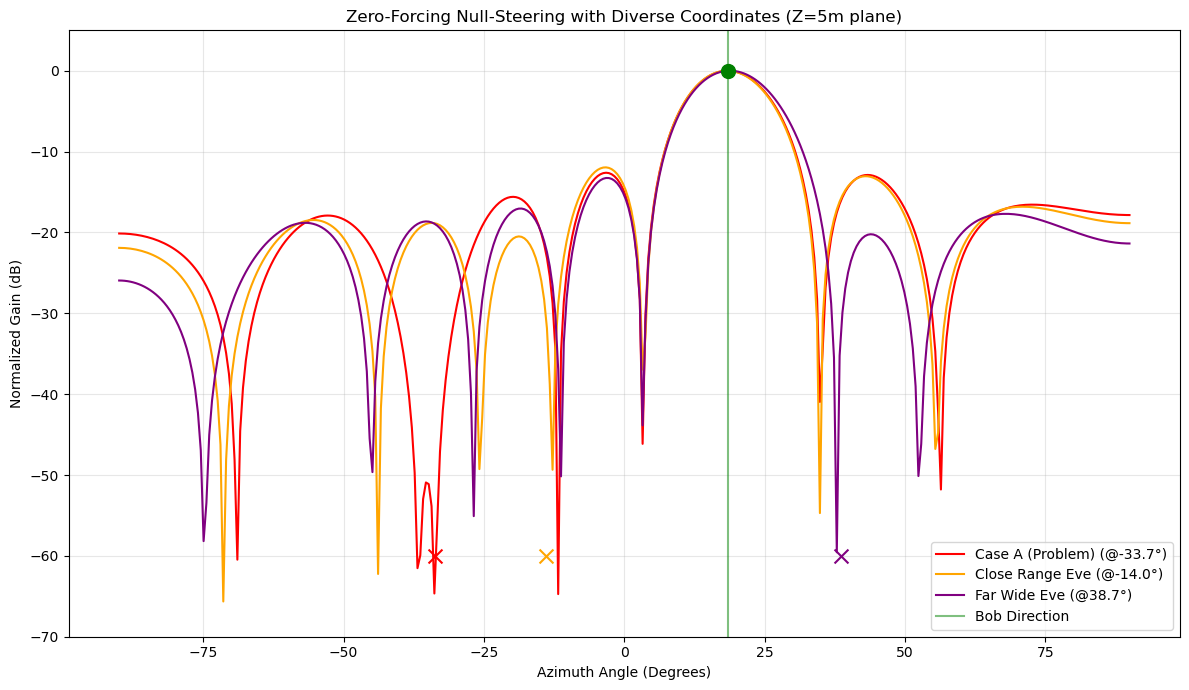

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Setup ---
Ny, Nz = 8, 8
d_lam = 0.5

def get_angles_from_xyz(x, y, z):
    # Calculate Azimuth (theta) and Elevation (phi) from coordinates
    theta = np.degrees(np.arctan2(y, x))
    phi = np.degrees(np.arctan2(z, x))
    return theta, phi

def get_steering_vector(theta_deg, phi_deg):
    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)
    n = np.arange(Ny)
    psi_y = 2 * np.pi * d_lam * n * np.sin(theta) * np.cos(phi)
    a_y = np.exp(-1j * psi_y)
    m = np.arange(Nz)
    psi_z = 2 * np.pi * d_lam * m * np.sin(phi)
    a_z = np.exp(-1j * psi_z)
    return np.kron(a_z, a_y).reshape(-1, 1)

# --- Define Coordinates ---
# Bob is fixed at (30, 10, 5)
bob_pos = (30, 10, 5)
theta_bob, phi_bob = get_angles_from_xyz(*bob_pos)
h_bob = get_steering_vector(theta_bob, phi_bob)

# Dictionary of Eves with diverse coordinates
eves = {
    "Case A (Problem)": (30, -20, 5),   # The required problem case
    "Close Range Eve":  (20, -5, 5),    # Test 1: Closer and negative angle
    "Far Wide Eve":     (50, 40, 5)     # Test 2: Further and positive angle
}

# --- Simulation & Plotting ---
plt.figure(figsize=(12, 7))
colors = ['red', 'orange', 'purple']

for i, (name, pos) in enumerate(eves.items()):
    # 1. Convert Eve's XYZ to Angles
    theta_eve, phi_eve = get_angles_from_xyz(*pos)

    # 2. Generate Channel & Weights
    h_eve = get_steering_vector(theta_eve, phi_eve)

    # Calculate Zero-Forcing Weights
    norm_eve_sq = np.real(np.vdot(h_eve, h_eve))
    P_eve = (h_eve @ h_eve.conj().T) / norm_eve_sq
    w_unscaled = (np.eye(Ny*Nz) - P_eve) @ h_bob

    # Normalise to Unity Gain at Bob
    gain_temp = np.vdot(w_unscaled, h_bob)
    w = w_unscaled * (1.0 / np.conj(gain_temp))

    # 3. Scan Pattern (Azimuth Cut at Bob's Elevation)
    scan_ax = np.linspace(-90, 90, 360)
    pattern = []
    for s in scan_ax:
        # We scan at Bob's elevation to see the main beam
        a_scan = get_steering_vector(s, phi_bob)
        resp = np.abs(np.vdot(w, a_scan))**2
        pattern.append(10 * np.log10(resp + 1e-9))

    # 4. Plot
    color = colors[i % len(colors)]
    plt.plot(scan_ax, pattern, color=color, linewidth=1.5, label=f'{name} (@{theta_eve:.1f}°)')
    # Mark the null
    plt.scatter([theta_eve], [-60], marker='x', s=100, color=color, zorder=10)

# Visuals
plt.axvline(theta_bob, color='green', linestyle='-', alpha=0.5, label='Bob Direction')
plt.scatter([theta_bob], [0], marker='o', s=100, color='green', zorder=10)
plt.title(f'Zero-Forcing Null-Steering with Diverse Coordinates (Z=5m plane)')
plt.xlabel('Azimuth Angle (Degrees)')
plt.ylabel('Normalized Gain (dB)')
plt.ylim(-70, 5)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()